<a href="https://colab.research.google.com/github/oscarvel821/cs482-assignments/blob/main/Final_Take_At_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

#Deep Learning For a Timeseries

Deep learning neural networks are able to automatically learn arbitrary complex mappings from inputs to outputs and support multiple inputs and outputs.

For this dataset the author uses MLP to learn the time series and make correct prediction.

Generally, neural networks like Multilayer Perceptrons or MLPs provide capabilities that are offered by few algorithms, such as:

* Robust to Noise. Neural networks are robust to noise in input data and in the mapping function and can even support learning and prediction in the presence of missing values.
* Nonlinear. Neural networks do not make strong assumptions about the mapping function and readily learn linear and nonlinear relationships.
* Multivariate Inputs. An arbitrary number of input features can be specified, providing direct support for multivariate forecasting.
* Multi-step Forecasts. An arbitrary number of output values can be specified, providing
direct support for multi-step and even multivariate forecasting.

For these capabilities alone, feedforward neural networks may be useful for time series forecasting.


#Data

In [2]:
# Original Data Source: https://fred.stlouisfed.org/series/RSXFSN
from google.colab import files
uploaded = files.upload()

Saving RSXFSN.csv to RSXFSN.csv


In [3]:
df = pd.read_csv("/content/RSXFSN.csv")

The author removes the data column because it is not necessary for our model, the author also tries to normalize the data because some of the values are too large and deep learning model usually like when the values are small

In [4]:
# keep real GDP only
keep_columns = ['RSXFSN']
df = df[keep_columns]
# rescale
df = df/10000 #tries to normalize the data

#Data Preprocessing

Typically we use random ways to split our data into train and test dataset but since we are working with a timeseries, we cannot use randomization. Here he uses the first 80% of the data for training and the last 20% for testing

In [5]:
# split train & test data
n_train = int(len(df) * 0.8)
n_test = len(df) - n_train
train, test = df.iloc[0:n_train], df.iloc[n_train:len(df)]
print(len(train), len(test))

300 75


We cannot fit the model like we usually do for problems like image processing beacuse this is a time series. What we can do to feed the network with certain number of values from the series X (where X is the number of RSXFXN at a given time [t, t - 1, t - 2, ... , t - n] ) and Y (where Y is the number of RSXFXN at the next given time [t + 1] ). This is what the following function is doing.

In [6]:
def get_timeseries(x, n_steps=1):
    x_ts, y_ts = [], []
    for ii in range(len(x) - n_steps):
        v = x.iloc[ii:(ii + n_steps)].values
        x_ts.append(v)
        w = x.iloc[ii + n_steps].values
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)

Here the author decided to use a window of 16, where they get X the number of RSXFXN at a given time (t, t - 1, t - 2, ... , t - 16) and Y the number of RSXFXN at the next given time (t + 1).

In [7]:
n_steps = 16
n_features = 1

# convert to a time series dimension: [samples, n_steps, n_features]

x_train, y_train = get_timeseries(train, n_steps)
x_test, y_test = get_timeseries(test,n_steps)

print(x_train.shape, y_train.shape)

(284, 16, 1) (284, 1)


#Modeling

Here we are pretty much just building the model with 1 input layer with 16 input nodes, 1 hidden layer with 64 nodes and and 1 output layer with 1 output node. I added the summary of the model to showcase the architecture of model a bit more

In [8]:
# define model
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=n_steps))
#model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(0.001))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                850       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


#Training

Here is where we are actually training the model with the hyperparameter of:

* epochs = 500
* batch size = 32
* validation split = 10%

In [10]:
# fit model
history = model.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/500
8/8 [==============================] - 6s 26ms/step - loss: 468.3116 - val_loss: 246.8226
Epoch 2/500
8/8 [==============================] - 0s 6ms/step - loss: 27.4162 - val_loss: 52.9860
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 59.9483 - val_loss: 117.9176
Epoch 4/500
8/8 [==============================] - 0s 6ms/step - loss: 28.0085 - val_loss: 19.8357
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 9.0846 - val_loss: 21.6858
Epoch 6/500
8/8 [==============================] - 0s 5ms/step - loss: 13.1614 - val_loss: 17.1772
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 7.9867 - val_loss: 12.9028
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 8.1998 - val_loss: 14.4429
Epoch 9/500
8/8 [==============================] - 0s 5ms/step - loss: 7.2996 - val_loss: 12.0275
Epoch 10/500
8/8 [==============================] - 0s 6ms/step - loss: 7.1883 - val_loss: 12.0227
Epoch 11/5

Now we want to see how the model will react with the testing datset

In [11]:
y_pred = model.predict(x_test)

2/2 [==============================] - 0s 3ms/step


The following statements detail the graph below:

* The green tend is the data that we used to train the model (the first 80% of the dataset), this is the tend that the model tried to learn.
* The blue tend is our test data (the last 20% of the dataset).
* The red tend is the predictions that our model made when we gave it the test data. 

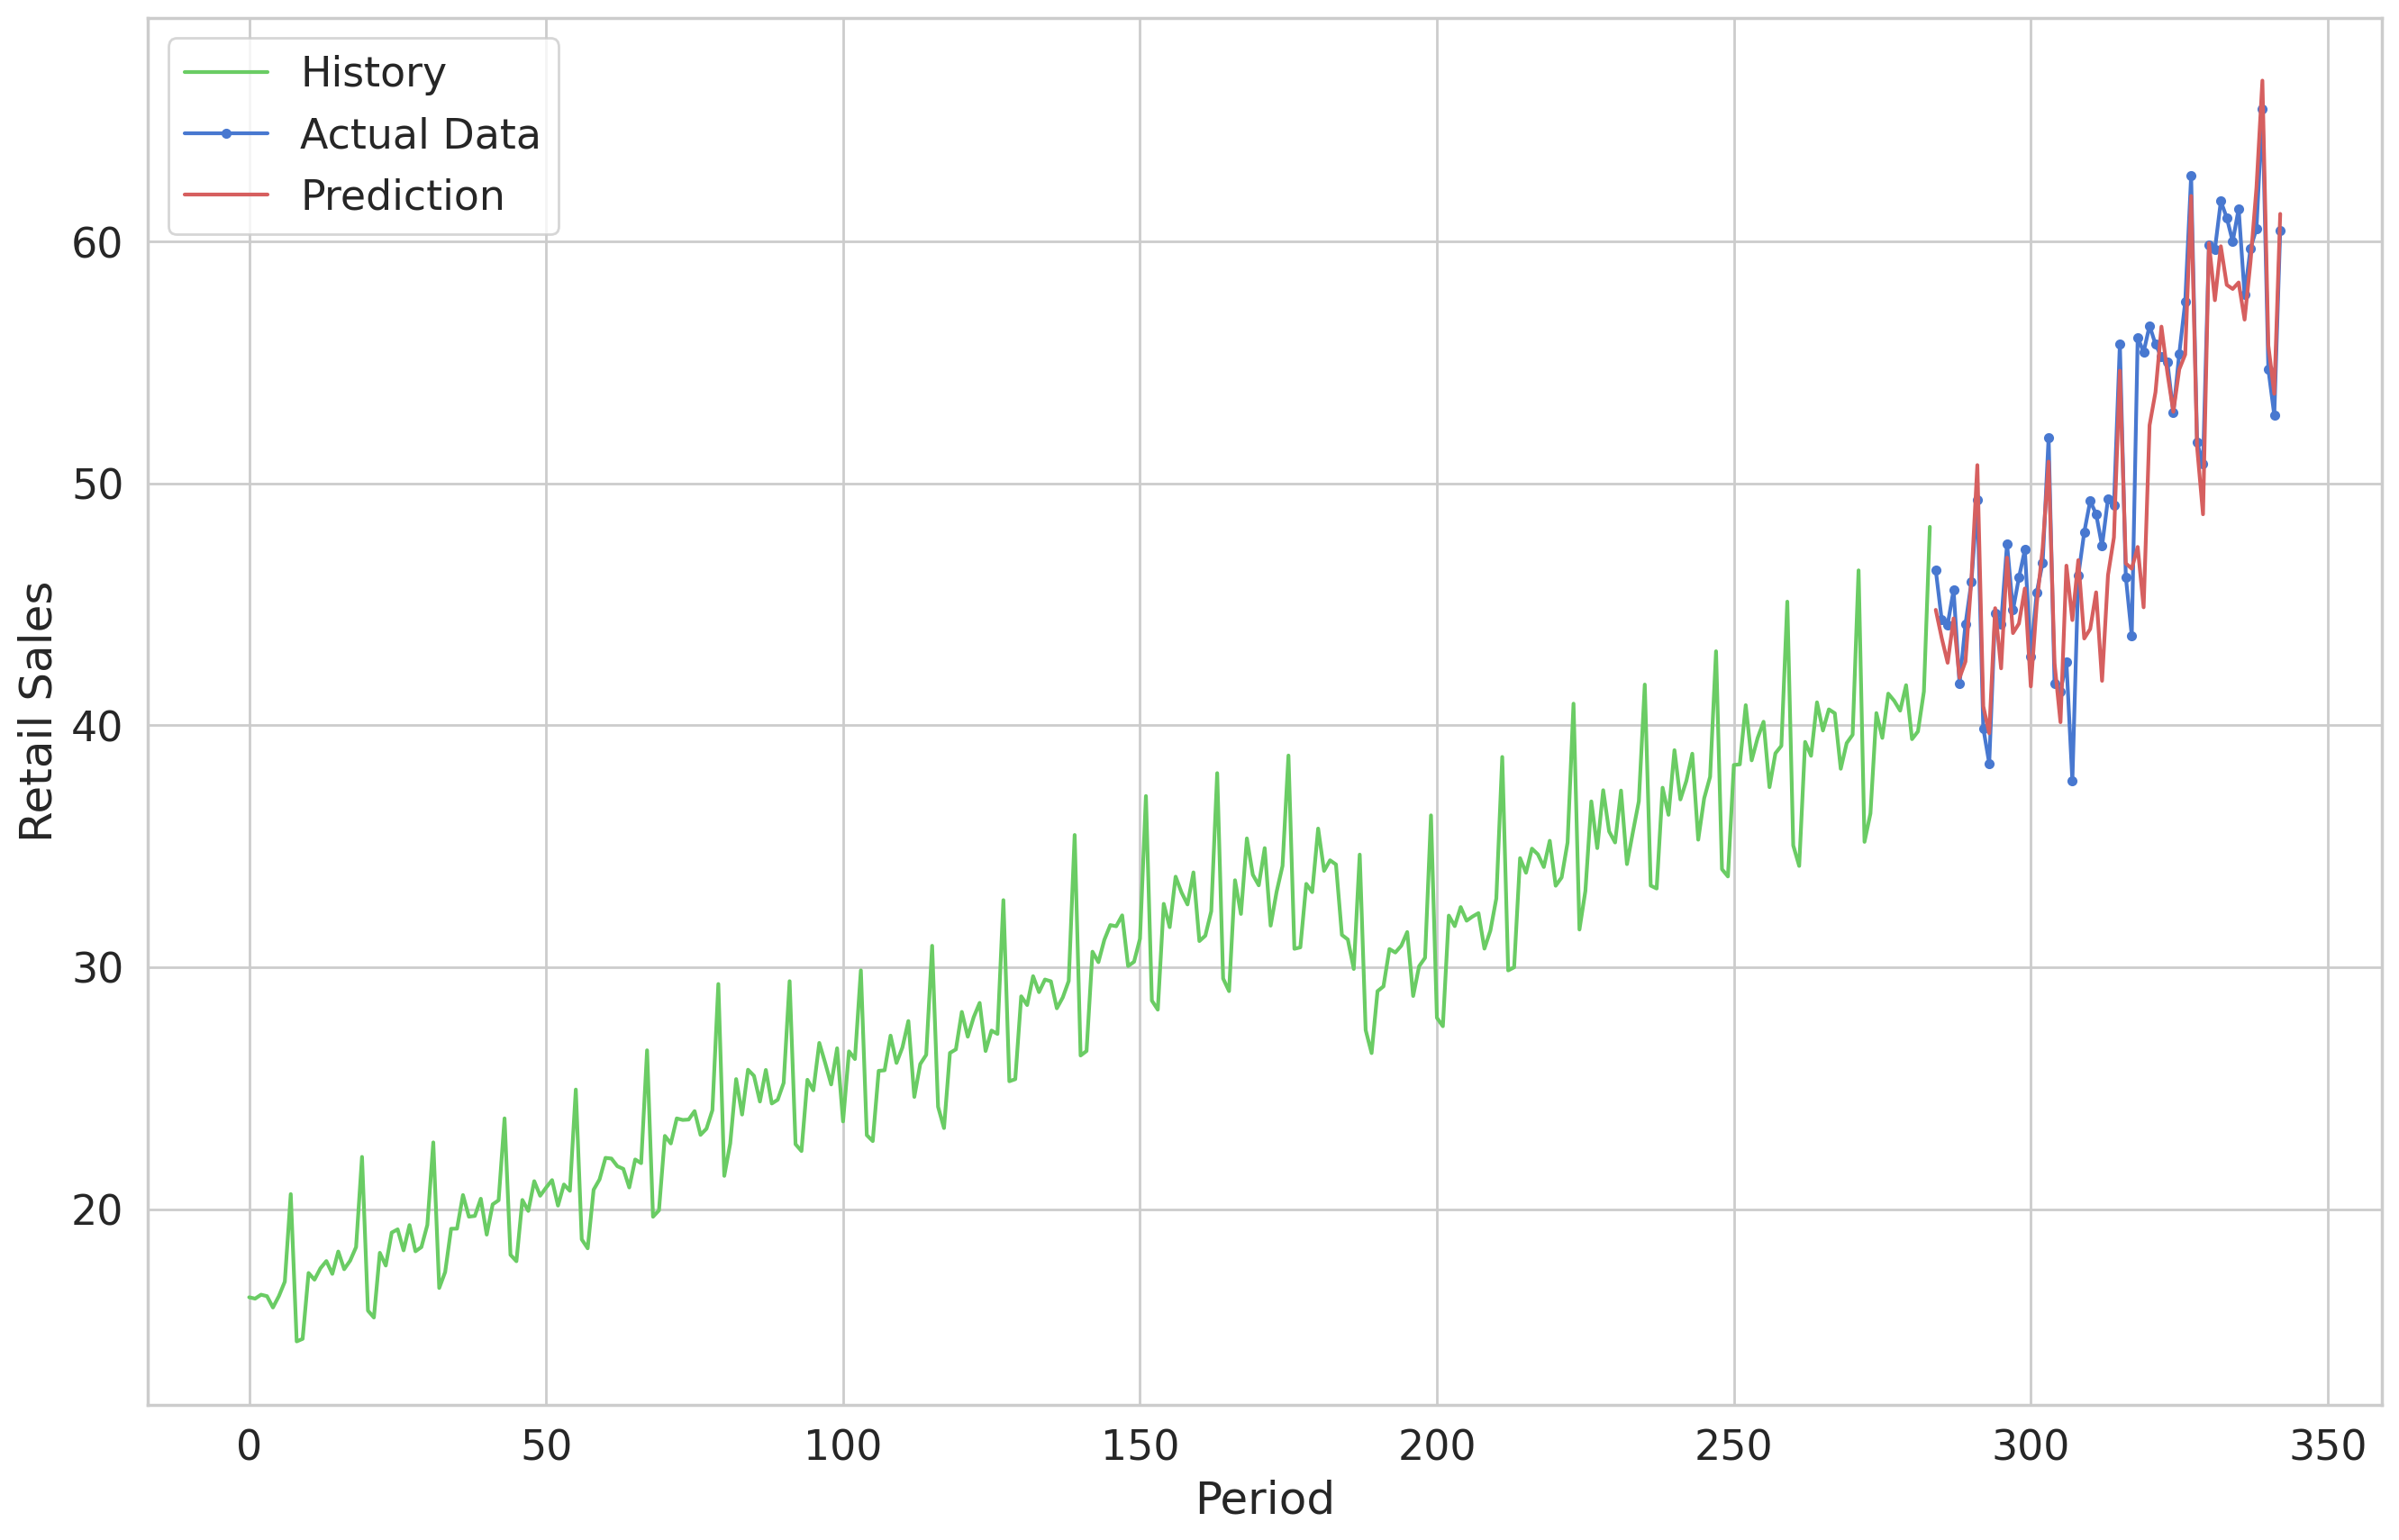

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

The graph below is just a closer look at the test data and the predictions that our model made when given the test data. As we can see the model predictions were not so far off from the actual data.

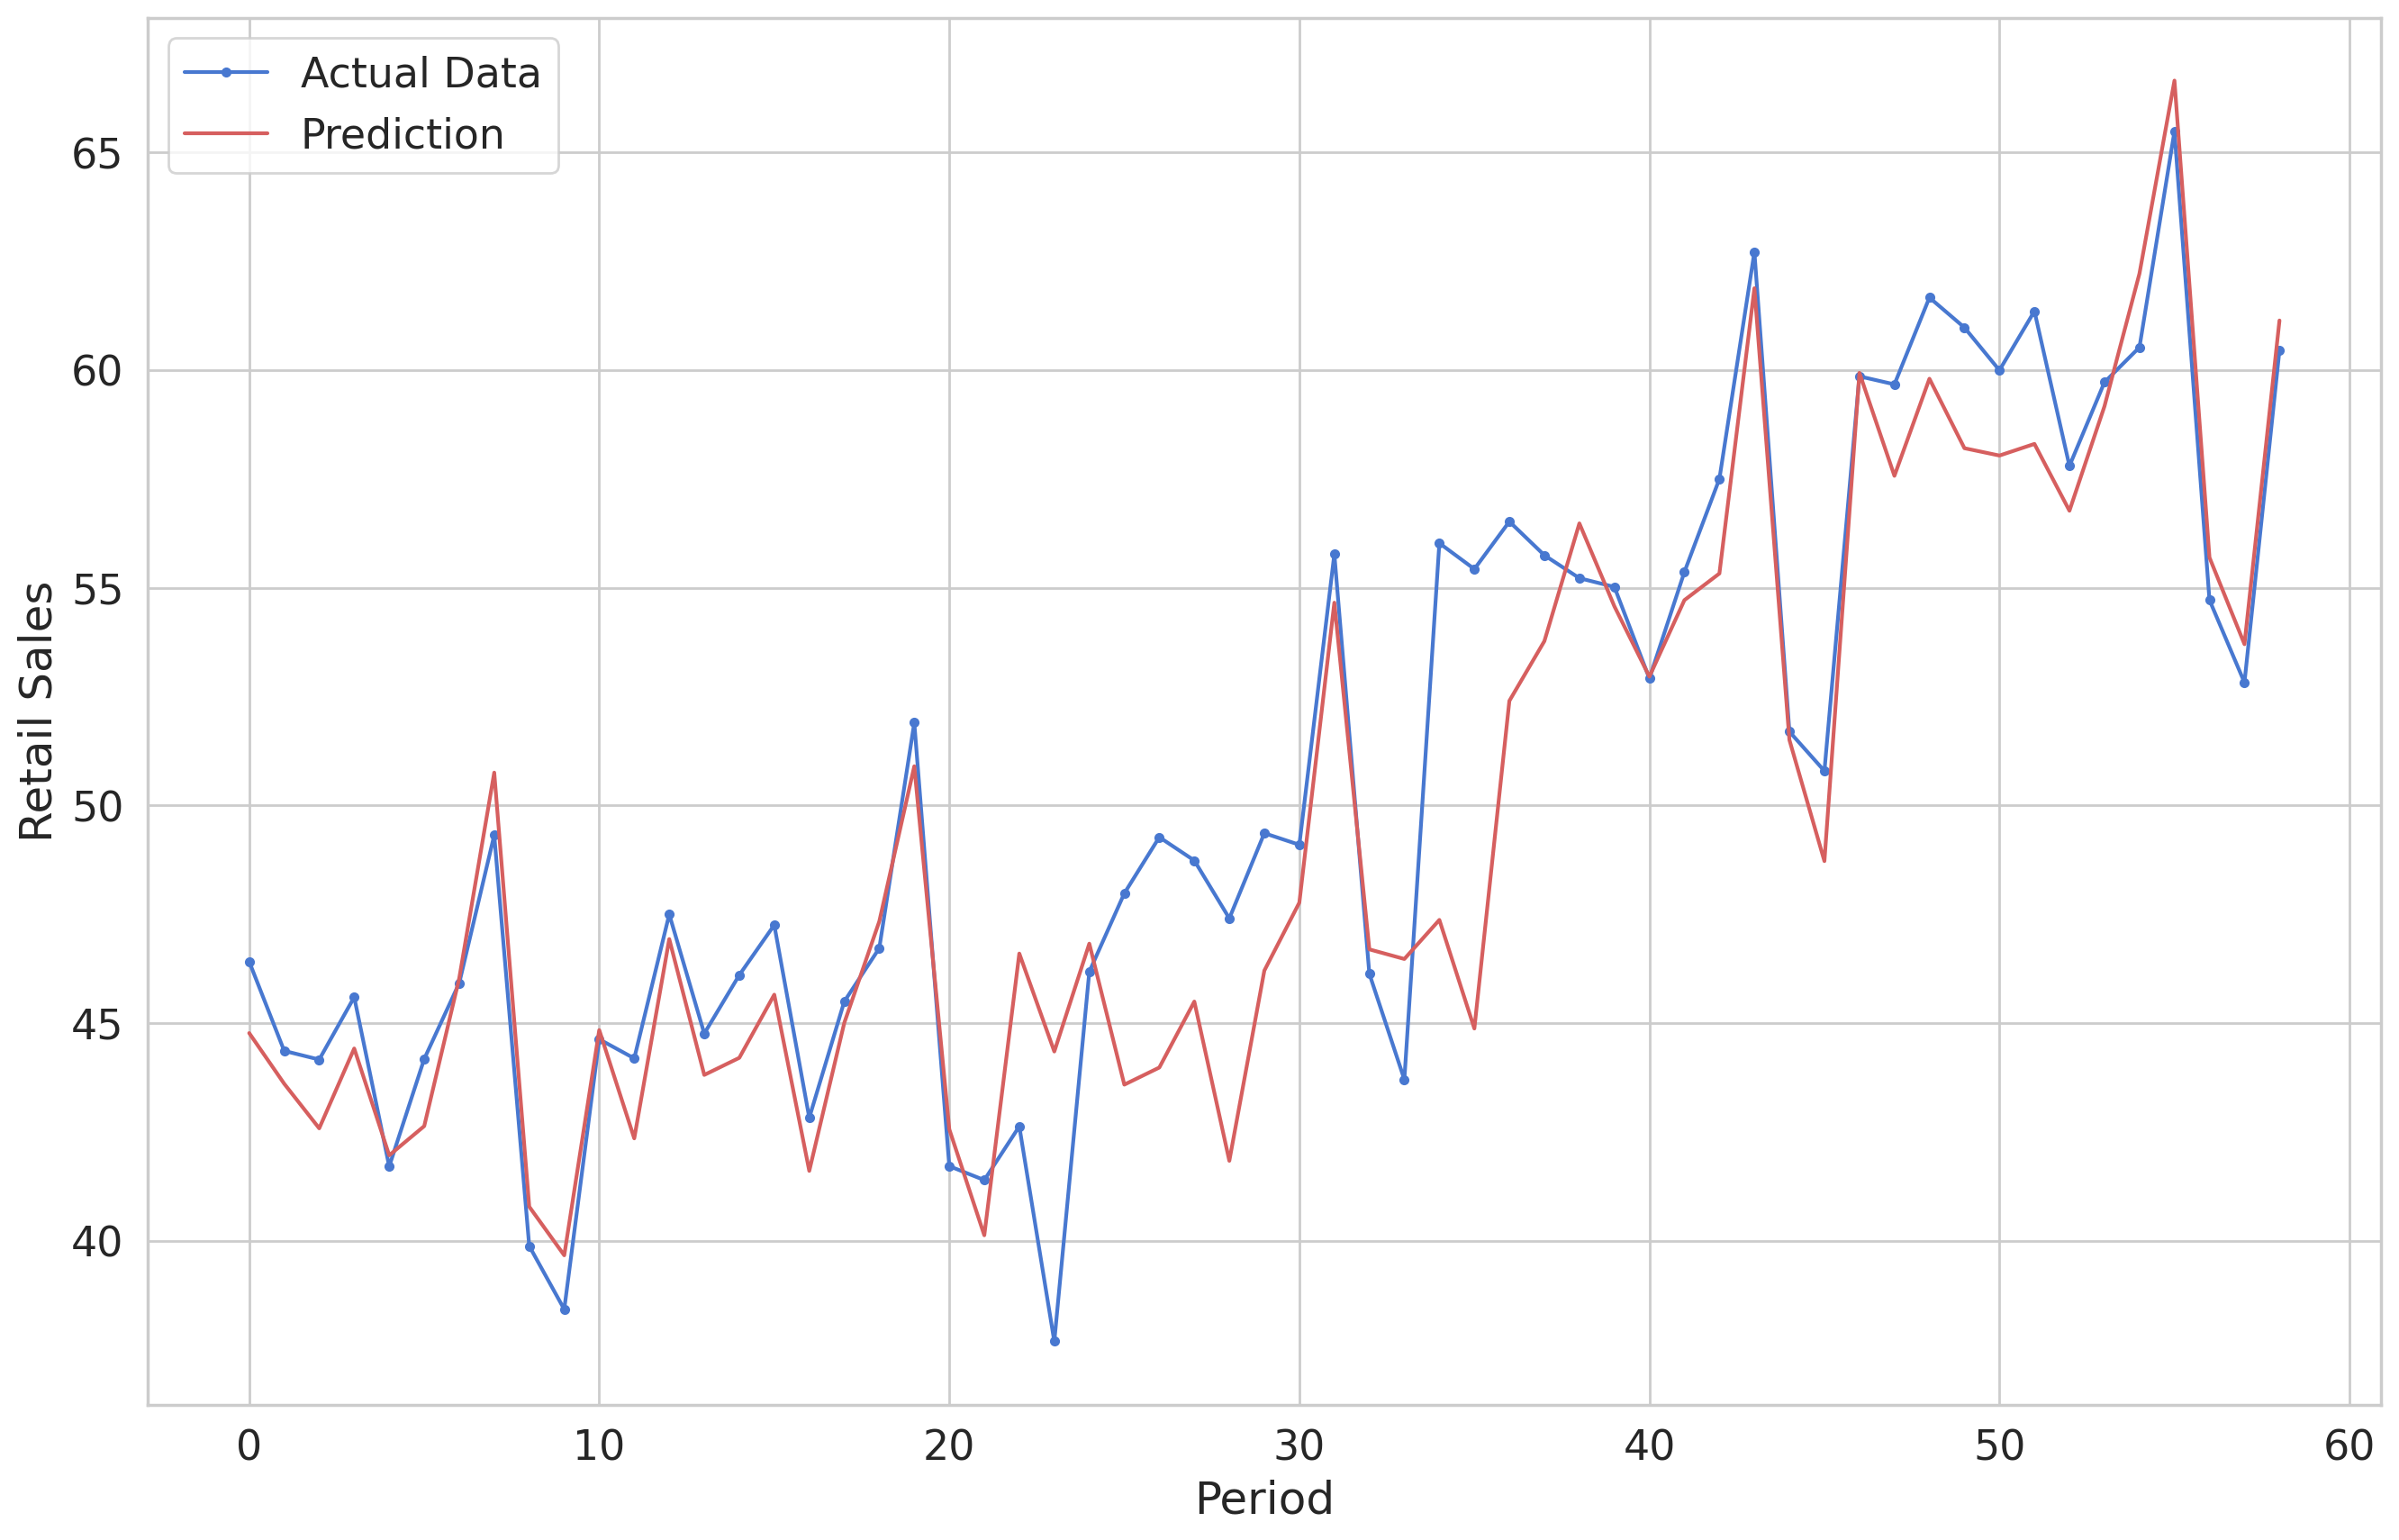

In [13]:
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

# Convolutional Neural Network Models for Time Series Forecasting
Now we are going to use a 1 dimensional Convoluational Neural Network Model to how it compare to MLP

Here we use one Conv1D layer with 64 filters and kernel size of 2 the input_shape is the same as our MLP model. We then use a pooling layer to distill the output of the convolutional layer to the most salient elements, we could've choose max or average pooling but I decided with max. After the pooling layer, we flatten the output to reduce the feature maps to a single one-dimensional vector. Finally we have two Dense layers like the ones we had in our MLP model.

In [14]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten

cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 1)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(1))
cnn.compile(optimizer='adam', loss='mse')

Quick summary of our CNN architecture 

In [15]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                28736     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,993
Trainable params: 28,993
Non-trainable params: 0
__________________________________________________

We trained our model with the same parameters from our MLP model

In [16]:
cnn_history = cnn.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/500
8/8 [==============================] - 7s 30ms/step - loss: 115.0607 - val_loss: 78.3237
Epoch 2/500
8/8 [==============================] - 0s 6ms/step - loss: 44.2370 - val_loss: 10.0092
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 20.2914 - val_loss: 40.8203
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 8.0253 - val_loss: 11.4706
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 8.7497 - val_loss: 8.3254
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 5.4890 - val_loss: 10.3194
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 4.7920 - val_loss: 7.4842
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 4.6193 - val_loss: 6.8919
Epoch 9/500
8/8 [==============================] - 0s 7ms/step - loss: 4.3515 - val_loss: 7.0120
Epoch 10/500
8/8 [==============================] - 0s 6ms/step - loss: 4.3189 - val_loss: 6.7452
Epoch 11/500
8/8 [=

Now lets see how the CNN model reacts with our testing data

In [17]:
cnn_y_pred = cnn.predict(x_test)

2/2 [==============================] - 0s 22ms/step


As we can see the CNN model predictions is quite similar to the MLP model, there is no significant difference. 

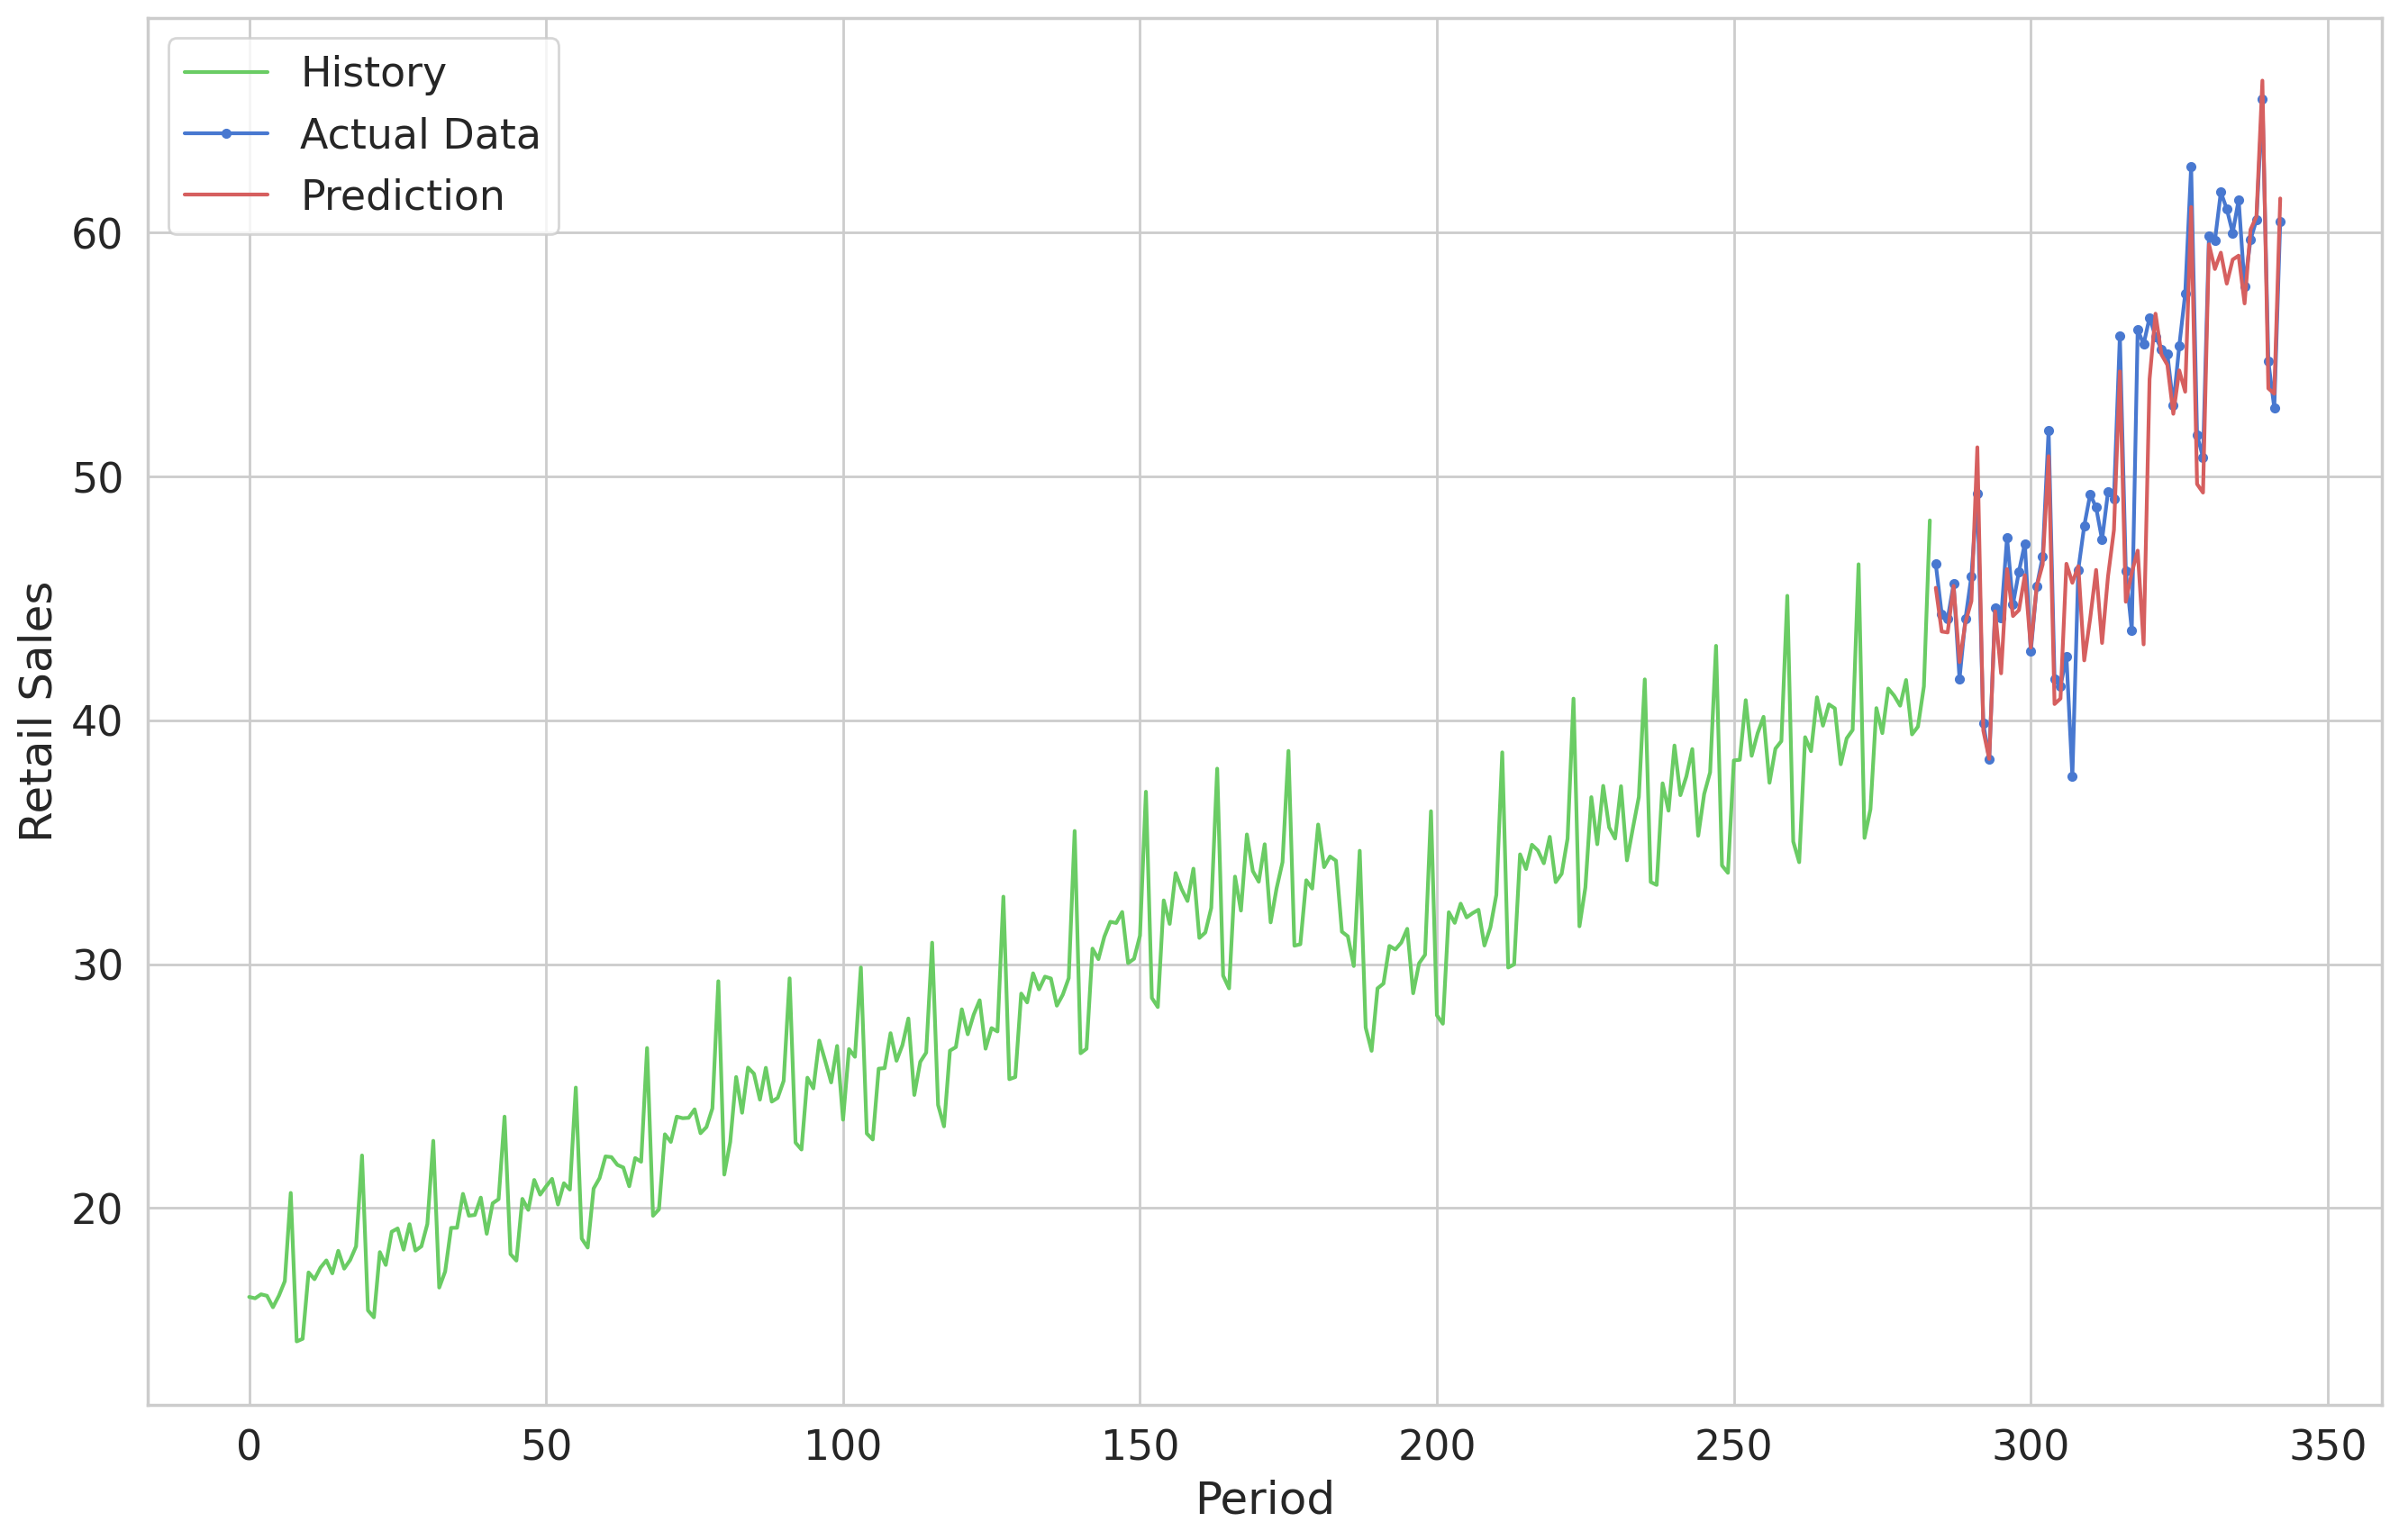

In [18]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), cnn_y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

Closer look at the actual data and the CNN predictions

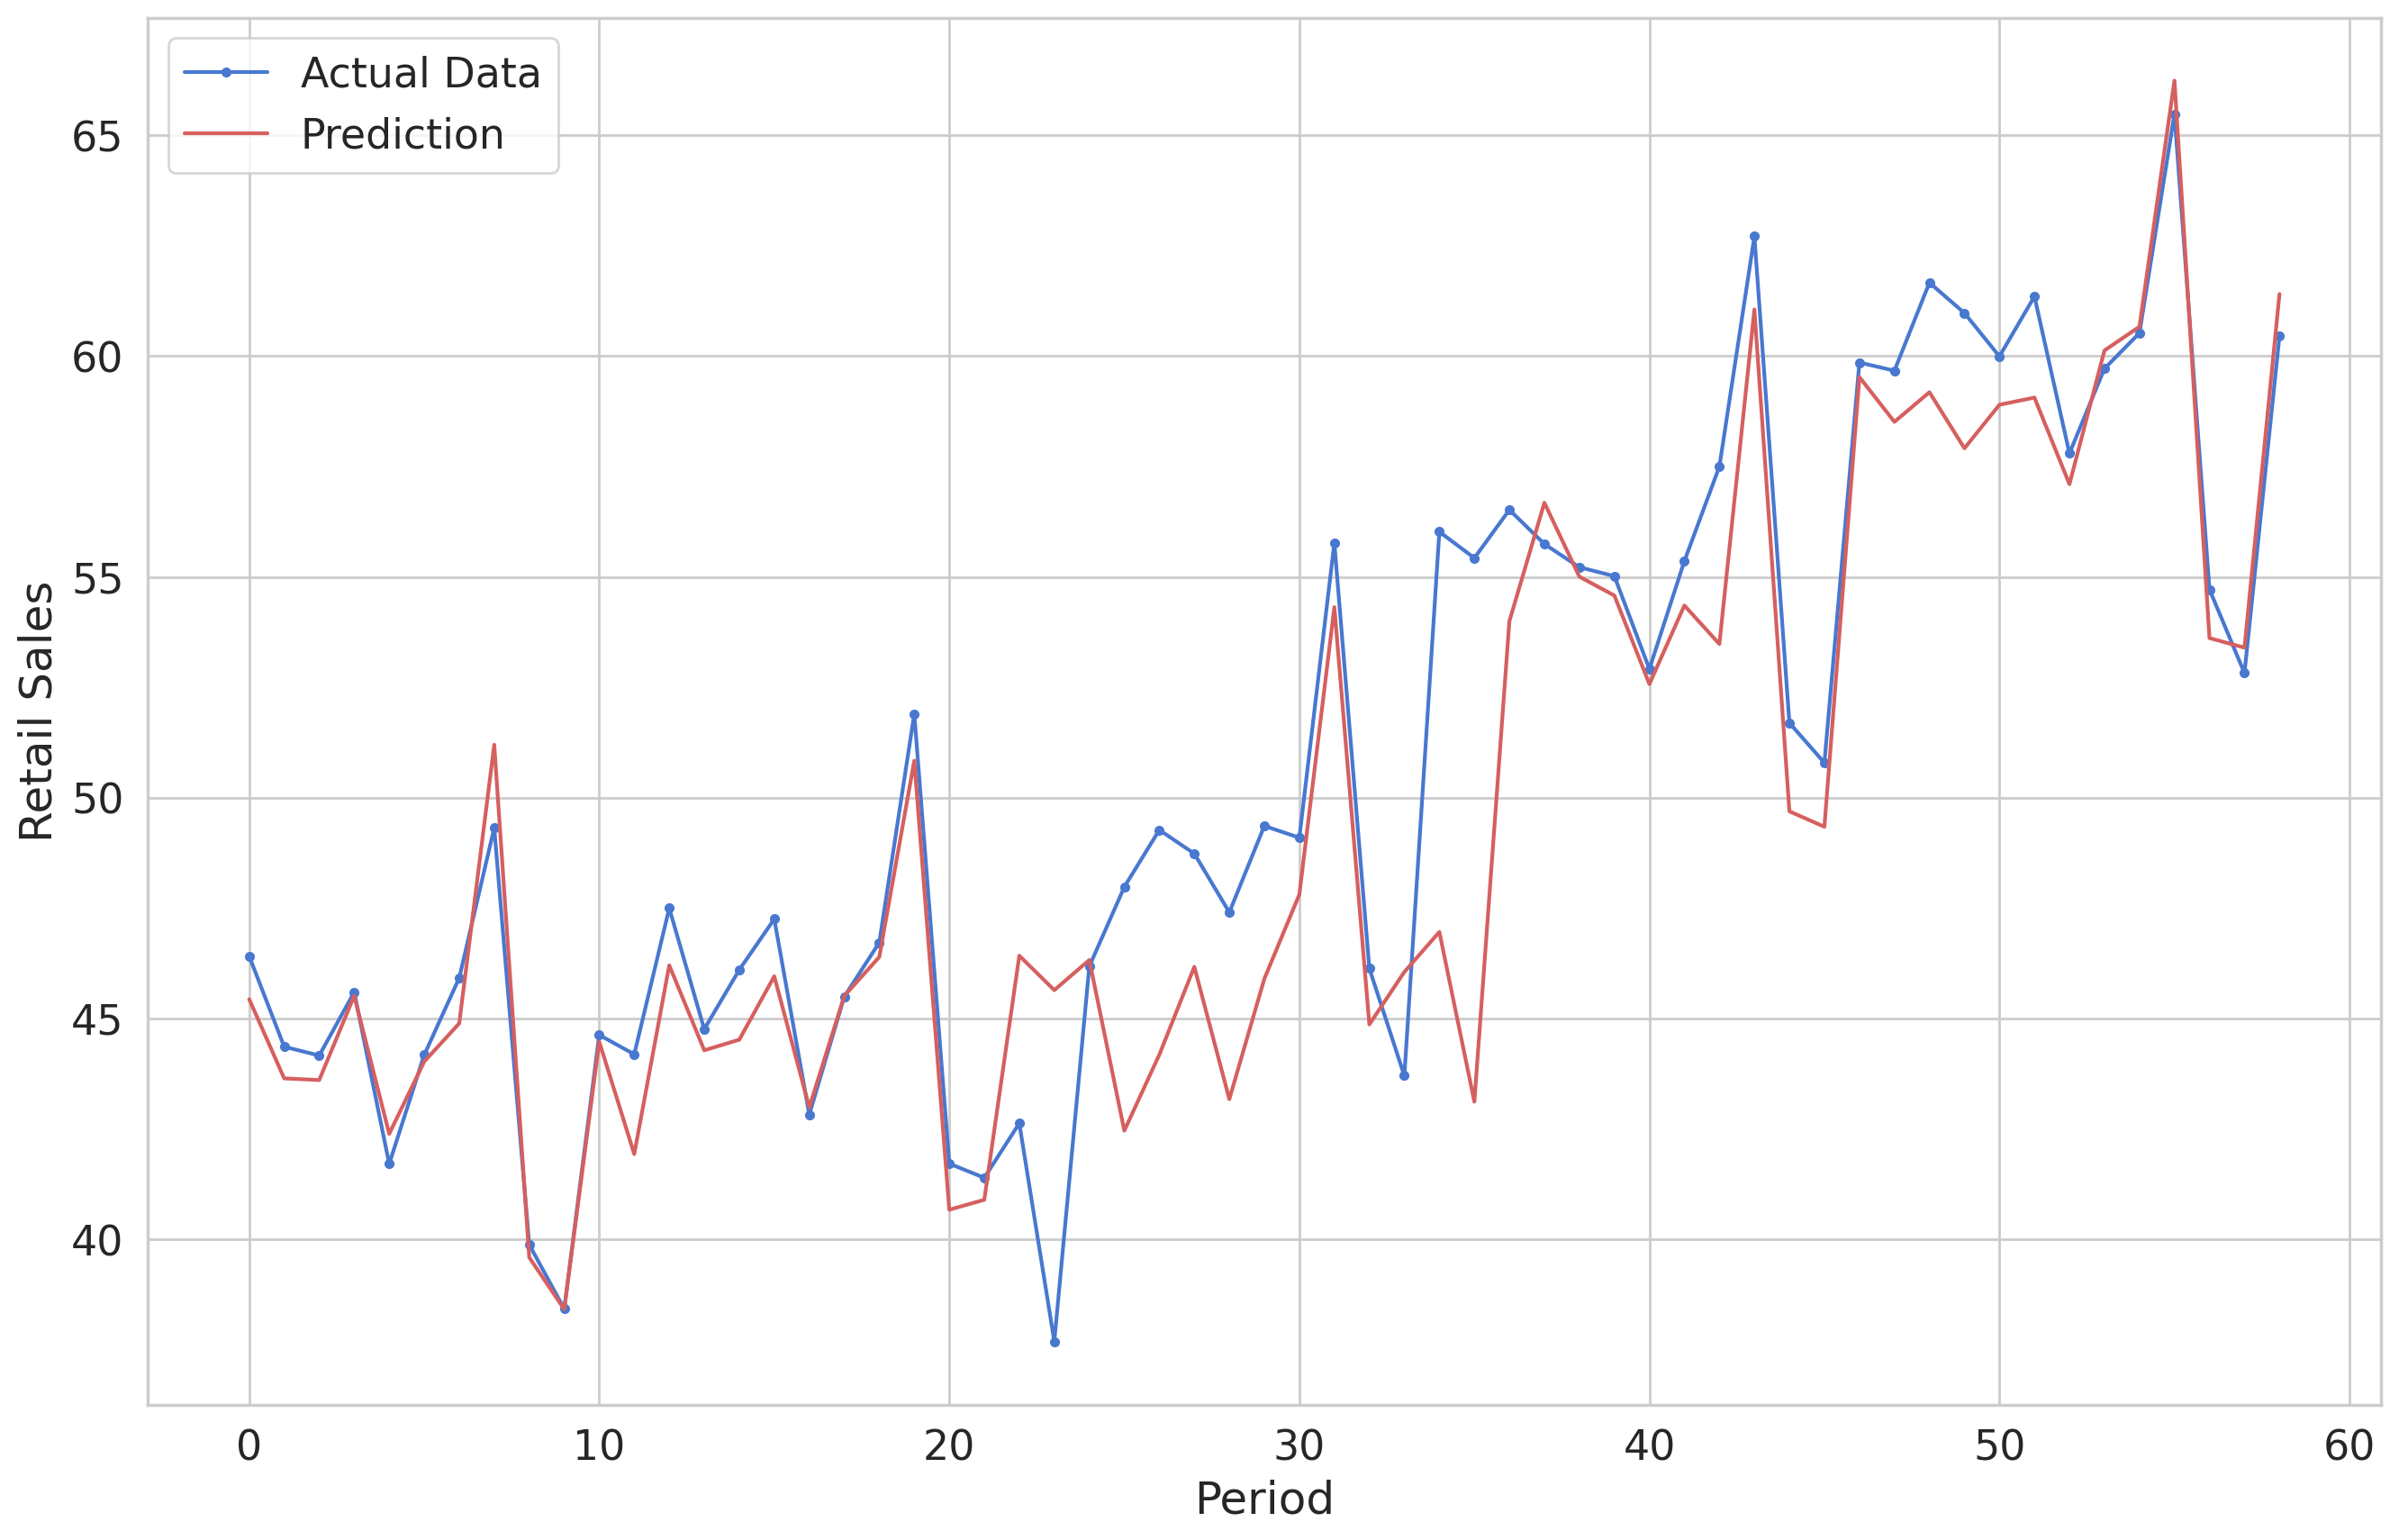

In [19]:
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(cnn_y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

When we take the Root Mean Squared Error from both models predictions then we see that the MLP model is slightly better. We can get better predictions if we change the hyperparameters or maybe add more hidden layers, it all depends on how we build the model.

In [20]:
def RMSE(y_true, y_pred):
  return ((y_true - y_pred) ** 2).mean()

In [30]:
print(f'RMSE for MLP model - {RMSE(y_test, y_pred)}')
print(f'loss value - {history.history["loss"][-1]}')
print(f'RMSE for CNN model - {RMSE(y_test, cnn_y_pred)}')
print(f'loss value - {cnn_history.history["loss"][-1]}')

RMSE for MLP model - 7.730020811245304
loss value - 0.7328541278839111
RMSE for CNN model - 8.41740071983364
loss value - 0.7310795783996582
